<a href="https://colab.research.google.com/github/srujayreddyv/CSC177-P2-LinearRegressionProject/blob/main/CSC177_P2_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC177- Project 2 Part A
# Data Preprocessing Project (Fall 2023)

## Team Challengers (23):
  1. Srujay Reddy Vangoor
  2. Vaibhav Jain
  3. Bashar Allwza
  4. Varun Bailapudi
  5. Uddayankith Chodagam

## Loading function definations and libraries


In [ ]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.4f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low


## Loading the dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving weatherHistory.csv to weatherHistory.csv


In [ ]:
df = pd.read_csv('weatherHistory.csv')
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [ ]:
df.shape

(96453, 12)

# Part A

In [ ]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

print(f"No. of training examples: {training_data.shape[0]}") # 80%
print(f"No. of testing examples: {testing_data.shape[0]}")  # 20%

No. of training examples: 77162
No. of testing examples: 19291


## Simple Linear Regression Model

Error: 0.0231
R-Squared Score: 0.4025
Mean Squared Error: 0.0231


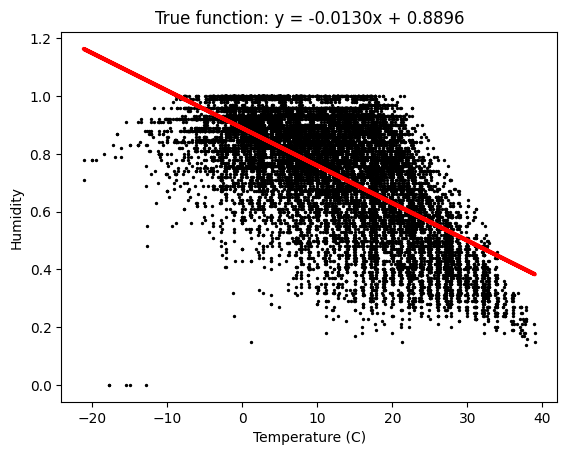

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


X = np.array(testing_data['Temperature (C)'])
y = np.array(testing_data['Humidity'])

# Calculate Slope and Intercept
m, b = np.polyfit(X.flatten(), y.flatten(), 1)
equation = f"y = {m:.4f}x + {b:.4f}"

#Plot
plt.scatter(X, y,  color='black',s=2)
plt.xlabel('Temperature (C)')
plt.ylabel('Humidity')
plt.plot(X, m*X + b, color='red', linewidth=3)
plt.title('True function: ' + equation)

# print the error
error = np.mean((m*X + b - y)**2)
print(f"Error: {error:.4f}")

from sklearn.metrics import r2_score, mean_squared_error
y_pred = m*X + b
print(f"R-Squared Score: {r2_score(y, y_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y, y_pred):.4f}")

## Multiple Regression Model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(training_data[['Temperature (C)']], training_data['Humidity'])

LinearRegression()

In [ ]:
# Apply model to the test set
y_pred_test = regr.predict(testing_data[['Temperature (C)']])

Root mean squared error = 0.1520
R-squared = 0.4025


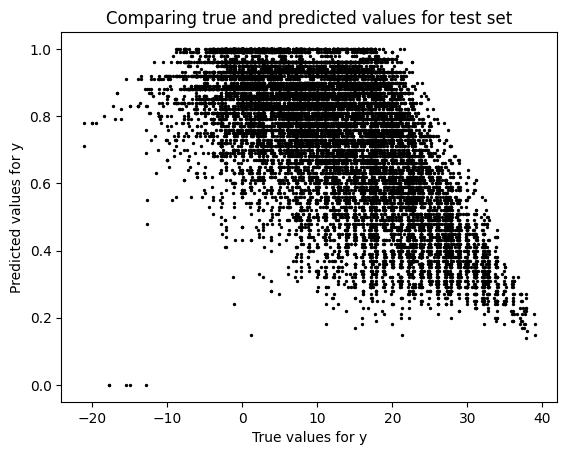

In [ ]:
# Comparing true versus predicted values
plt.scatter(testing_data['Temperature (C)'], testing_data['Humidity'],  color='black',s=2)
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(testing_data['Humidity'], y_pred_test)))
print('R-squared = %.4f' % r2_score(testing_data['Humidity'], y_pred_test))


Slope =  -0.012926424493223962
Intercept =  0.8892169425236056


Text(0, 0.5, 'Humidity')

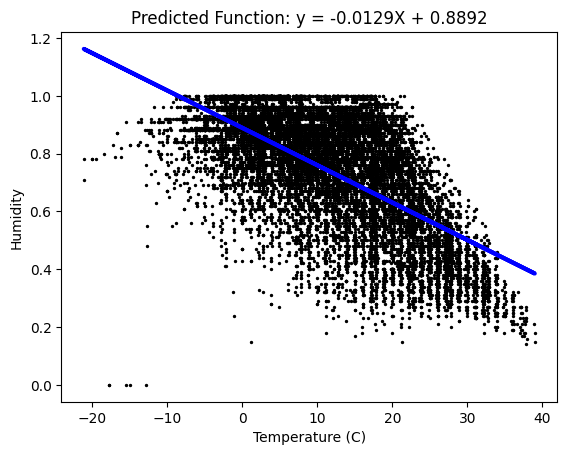

In [ ]:
# Display model parameters
print('Slope = ', regr.coef_[0])
print('Intercept = ', regr.intercept_)### Step 4: Postprocessing

# Plot outputs
plt.scatter(testing_data['Temperature (C)'], testing_data['Humidity'],  color='black',s=2)
plt.plot(testing_data['Temperature (C)'], y_pred_test, color='blue', linewidth=3)
titlestr = 'Predicted Function: y = %.4fX + %.4f' % (regr.coef_[0], regr.intercept_)
plt.title(titlestr)
plt.xlabel('Temperature (C)')
plt.ylabel('Humidity')

# Analysis

We find that there is a strong relationship between the temperature and humidity. Based on our findings, as the temperature increases, the humidity of will descrease. Theoretically, this makes sense because as the temperature rises, the amount of moisture in the air will decrease due to evaporation. This is an inverse relationship.